In [2]:
import os
import shutil

import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

plt.rcParams["figure.figsize"] = 10, 6

%config InlineBackend.figure_format = "svg"

%env CUDA_VISIBLE_DEVICES=0
%env OMP_NUM_THREADS=8

torch.set_num_threads(8)

SEED = 44
torch.manual_seed(SEED)
np.random.seed(SEED)

env: CUDA_VISIBLE_DEVICES=0
env: OMP_NUM_THREADS=8


## Prepare data

In [3]:
#!kaggle competitions download -c vk-made-sports-image-classification

In [4]:
#!unzip vk-made-sports-image-classification.zip
#!mv train full_train
#!mv test full_test

In [5]:
whole_train = pd.read_csv("train.csv")
whole_train.sample(n=10, random_state=SEED)

,image_id,label
31847,8b71c806-03a0-4988-a2e6-4c670b5607d5.jpeg,tennis
14666,c560a042-341d-46f6-a258-2ab33527967b.jpeg,handball
22241,08738e2d-55b6-4032-9f2b-d924674f06a2.jpeg,ski_race
28622,84a04b74-61b4-420f-a62f-19f475f5533d.jpeg,fencing
6245,b286357e-de1d-4666-b02d-f79cb7b8b859.jpeg,boxing
27666,0b5a1e8a-6c05-45c4-90ee-39cb9e3ca77d.jpeg,ski_race
21947,345b53ae-18d5-4037-9561-99611d451037.jpeg,pole_vault
17026,0780bb9f-b468-44f6-ac86-d9396a3ef8ae.jpeg,gymnastics
18420,8ac2d6da-b57b-4084-9008-3f2548cb5a2a.jpeg,gymnastics
26862,90b706c3-e75f-41e7-895b-7302c0dfda62.jpeg,surfing


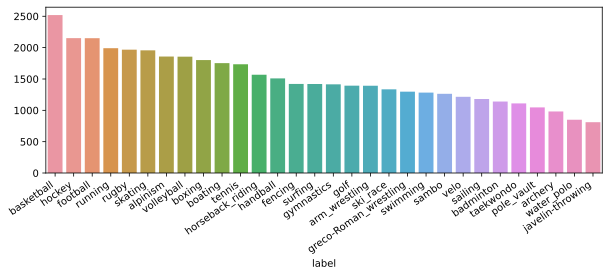

In [6]:
counts = whole_train["label"].value_counts()

plt.figure(figsize=(10, 3))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=35, ha="right")
plt.show()

In [7]:
whole_train.label.nunique(), whole_train.shape

(30, (45373, 2))

In [8]:
# To use torchvision.datasets.ImageFolder

for label in whole_train.label.unique():
    pass
    #os.mkdir(f"full_train/{label}")

for idx, path, label in whole_train.itertuples():
    pass
    #os.replace(f"full_train/{path}", f"full_train/{label}/{path}")

In [9]:
trainval, test = train_test_split(whole_train, test_size=0.1, random_state=SEED)
train, val = train_test_split(trainval, test_size=0.1, random_state=SEED)

In [10]:
whole_train_counts = whole_train.label.value_counts()
whole_train_counts.name = "whole_train"

train_counts = train.label.value_counts()
train_counts.name = "train"

val_counts = val.label.value_counts()
val_counts.name = "val"

test_counts = test.label.value_counts()
test_counts.name = "test"

pd.concat([whole_train_counts, train_counts, val_counts, test_counts], axis=1)

,whole_train,train,val,test
label,,,,
basketball,2519,2029,224,266
hockey,2151,1753,188,210
football,2150,1728,197,225
running,1991,1620,164,207
rugby,1967,1577,182,208
skating,1957,1602,177,178
alpinism,1858,1531,163,164
volleyball,1856,1521,167,168
boxing,1801,1479,153,169


In [11]:
part2df = {
    "train": train,
    "val": val,
    "test": test,
}


for part in part2df:
    #os.mkdir(part)
    
    for label in whole_train.label.unique():
        pass
        #os.mkdir(f"{part}/{label}")
    
    for idx, path, label in part2df[part].itertuples():
        pass
        #shutil.copyfile(f"full_train/{label}/{path}", f"{part}/{label}/{path}")

In [12]:
!du -a full_train/* | wc -l
!du -a train/* | wc -l
!du -a val/* | wc -l
!du -a test/* | wc -l

45403
36781
4114
4568


In [13]:
len(whole_train), len(train), len(val), len(test)

(45373, 36751, 4084, 4538)

## Training

In [14]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

tr = EfficientNet_V2_L_Weights.DEFAULT.transforms()
tr

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
whole_ds = torchvision.datasets.ImageFolder("full_train", transform=tr)
train_ds = torchvision.datasets.ImageFolder("train", transform=tr)
val_ds = torchvision.datasets.ImageFolder("val", transform=tr)
test_ds = torchvision.datasets.ImageFolder("test", transform=tr)

bs = 128
whole_dataloader = torch.utils.data.DataLoader(whole_ds, batch_size=bs, shuffle=True, num_workers=4)
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=4)

In [16]:
assert torch.cuda.is_available()
device = "cuda:0"

In [17]:
model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
model.eval()
pass

In [18]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

count_params(model.features[-1])

821760

In [19]:
for p in model.parameters():
    p.requires_grad_(False)

#for p in model.features[-1].parameters():
#    p.requires_grad_(True)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_ds.classes))

model.to(device)

model.classifier[1]

Linear(in_features=1280, out_features=30, bias=True)

In [20]:
count_params(model)

117272702

In [21]:
count_params(model.classifier[1])

38430

In [22]:
def train_one_epoch(model, dataloader, optimizer, criterion, scheduler=None, device="cuda:0"):
    model.train()
    
    losses = []
    all_labels = []
    all_preds = []
    
    for imgs, labels in tqdm(dataloader, desc="train"):
        optimizer.zero_grad()

        imgs = imgs.to(device)
        labels = labels.to(device)
        
        logits = model(imgs)
        
        loss = criterion(logits, labels)
        loss.backward()

        preds = logits.argmax(-1)
        
        all_labels.append(labels.detach().cpu())
        all_preds.append(preds.detach().cpu())        
        losses.append(loss.item())
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step(optimizer)
    
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    microf1 = f1_score(all_labels, all_preds, average="micro")
    accuracy = (all_labels == all_preds).mean()
    
    metrics = {
        "micro_f1": microf1, 
        "accuracy": accuracy, 
        "total_loss": np.mean(losses),
    }
    
    return losses, metrics

In [23]:
@torch.no_grad()
def eval_model(model, dataloader, criterion, device="cuda:0"):
    model.eval()
    
    total_loss = 0
    total_samples = 0
    
    all_labels = []
    all_preds = []
    
    for imgs, labels in tqdm(dataloader, desc="eval"):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        logits = model(imgs)
        loss = criterion(logits, labels)
        
        total_loss += loss.item() * len(labels)
        total_samples += len(labels)
        
        preds = logits.argmax(-1)

        all_labels.append(labels.detach().cpu())
        all_preds.append(preds.detach().cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    microf1 = f1_score(all_labels, all_preds, average="micro")
    accuracy = (all_labels == all_preds).mean()
    
    total_loss /= total_samples
    
    return {
        "micro_f1": microf1, 
        "accuracy": accuracy, 
        "total_loss": total_loss,
    }

In [24]:
class_probs = (train.label.value_counts() / len(train))

weights = 1 / class_probs[train_ds.classes]

# if all weights are equal to 1, weights sum to number of classes,
# so I rescale the weights.
weights = len(train_ds.classes) * weights / weights.sum()

weights = torch.from_numpy(weights.values).float().to(device)

weights

tensor([0.7406, 1.4630, 1.0043, 1.2024, 0.5588, 0.7979, 0.7666, 1.0105, 0.6562,
        0.9894, 1.0747, 1.0105, 0.9456, 0.6468, 0.8984, 1.7153, 1.3579, 0.7190,
        0.6999, 1.1923, 1.1105, 0.7078, 1.0616, 0.9791, 1.1062, 1.2473, 0.7879,
        1.1534, 0.7455, 1.6504], device='cuda:0')

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.01)
#criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

In [25]:
out = model(torch.randn(32, 3, 480, 480).to(device))
out.shape

torch.Size([32, 30])

In [26]:
n_epochs = 5

all_train_metrics = []
all_val_metrics = []
batch_losses = []

for epoch in range(n_epochs):
    losses, train_metrics = train_one_epoch(model, train_dataloader, optimizer, criterion)
    val_metrics = eval_model(model, val_dataloader, criterion)
    #train_metrics = eval_model(model, train_dataloader, criterion)
    
    batch_losses.extend(losses)    
    all_train_metrics.append(train_metrics)
    all_val_metrics.append(val_metrics)
    
    print("Train:", train_metrics)
    print("Val:", val_metrics)

eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:58<00:00,  2.19it/s]


Train: {'micro_f1': 0.6606895050474817, 'accuracy': 0.6606895050474817, 'total_loss': 1.5803540451200866}
Val: {'micro_f1': 0.8452497551420176, 'accuracy': 0.8452497551420176, 'total_loss': 0.8635466313618988}


eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:57<00:00,  2.21it/s]


Train: {'micro_f1': 0.7997333405893718, 'accuracy': 0.7997333405893717, 'total_loss': 0.8675699504278762}
Val: {'micro_f1': 0.8667972575905974, 'accuracy': 0.8667972575905974, 'total_loss': 0.6675567512822782}


eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:57<00:00,  2.23it/s]


Train: {'micro_f1': 0.818998122500068, 'accuracy': 0.818998122500068, 'total_loss': 0.7577051148402162}
Val: {'micro_f1': 0.8812438785504407, 'accuracy': 0.8812438785504407, 'total_loss': 0.5987734007088141}


eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:55<00:00,  2.30it/s]


Train: {'micro_f1': 0.8260727599249, 'accuracy': 0.8260727599249, 'total_loss': 0.7173237692697656}
Val: {'micro_f1': 0.8829578844270323, 'accuracy': 0.8829578844270323, 'total_loss': 0.579720707907616}


eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:57<00:00,  2.21it/s]

Train: {'micro_f1': 0.832984136486082, 'accuracy': 0.832984136486082, 'total_loss': 0.6910070155992831}
Val: {'micro_f1': 0.8895690499510284, 'accuracy': 0.8895690499510284, 'total_loss': 0.5556159740738957}


In [27]:
torch.save(model.state_dict(), "effnet_5_epochs_local_train.pth")

In [28]:
pd.DataFrame(all_train_metrics)

,micro_f1,accuracy,total_loss
0,0.660690,0.660690,1.580354
1,0.799733,0.799733,0.867570
2,0.818998,0.818998,0.757705
3,0.826073,0.826073,0.717324
4,0.832984,0.832984,0.691007


In [29]:
pd.DataFrame(all_val_metrics)

,micro_f1,accuracy,total_loss
0,0.845250,0.845250,0.863547
1,0.866797,0.866797,0.667557
2,0.881244,0.881244,0.598773
3,0.882958,0.882958,0.579721
4,0.889569,0.889569,0.555616


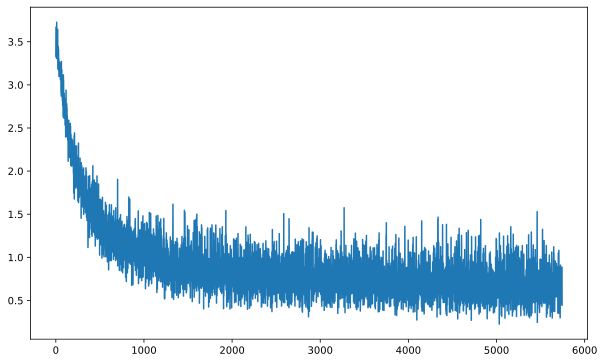

In [30]:
plt.plot(batch_losses)

In [31]:
n_epochs = 2

whole_metrics = []
whole_losses = []

for epoch in range(n_epochs):
    losses, metrics = train_one_epoch(model, whole_dataloader, optimizer, criterion)
    
    whole_losses.extend(losses)
    whole_metrics.append(metrics)
    
    print("Metrics:", metrics)

train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1418/1418 [16:20<00:00,  1.45it/s]


Metrics: {'micro_f1': 0.8332488484340907, 'accuracy': 0.8332488484340907, 'total_loss': 0.6859798676561569}


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1418/1418 [21:37<00:00,  1.09it/s]

Metrics: {'micro_f1': 0.8358274744892337, 'accuracy': 0.8358274744892337, 'total_loss': 0.6694894009420834}


In [32]:
#torch.save(model.state_dict(), "effnet_5_epochs_local_train_2_epochs_whole_train.pth")

In [26]:
model.load_state_dict(torch.load("effnet_5_epochs_local_train_2_epochs_whole_train.pth"))

<All keys matched successfully>

In [27]:
@torch.no_grad()
def predict_model(model, dataloader, device="cuda:0"):
    model.eval()
    
    all_preds = []
    all_logits = []
    
    for imgs, _ in tqdm(dataloader, desc="predict"):
        imgs = imgs.to(device)
        
        logits = model(imgs)
        
        preds = logits.argmax(-1)

        all_logits.append(logits.detach().cpu())
        all_preds.append(preds.detach().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_logits = torch.cat(all_logits).numpy()
    
    return all_preds, all_logits

In [28]:
#!mkdir full_test/unknown
#!mv full_test/* full_test/unknown

In [29]:
full_test_ds = torchvision.datasets.ImageFolder("full_test", transform=tr)
full_test_dataloader = torch.utils.data.DataLoader(full_test_ds, bs, shuffle=False)

In [30]:
all_preds, all_logits = predict_model(model, full_test_dataloader)

predict: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [04:41<00:00,  1.85s/it]


In [31]:
np.unique(all_preds, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 749,  424,  668,  605, 1013,  707,  696,  649,  964,  642,  612,
         591,  632,  911,  673,  325,  468,  788,  831,  561,  555,  814,
         620,  595,  487,  526,  721,  542,  704,  373]))

In [32]:
idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
idx_to_class

{0: 'alpinism',
 1: 'archery',
 2: 'arm_wrestling',
 3: 'badminton',
 4: 'basketball',
 5: 'boating',
 6: 'boxing',
 7: 'fencing',
 8: 'football',
 9: 'golf',
 10: 'greco-Roman_wrestling',
 11: 'gymnastics',
 12: 'handball',
 13: 'hockey',
 14: 'horseback_riding',
 15: 'javelin-throwing',
 16: 'pole_vault',
 17: 'rugby',
 18: 'running',
 19: 'sailing',
 20: 'sambo',
 21: 'skating',
 22: 'ski_race',
 23: 'surfing',
 24: 'swimming',
 25: 'taekwondo',
 26: 'tennis',
 27: 'velo',
 28: 'volleyball',
 29: 'water_polo'}

In [33]:
whole_test = pd.read_csv("test.csv")
whole_test = whole_test.sort_values("image_id")
whole_test["label"] = all_preds
whole_test["label"] = whole_test["label"].map(idx_to_class)
whole_test = whole_test.sort_index()
whole_test

,image_id,label
0,00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg,ski_race
1,ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg,basketball
2,ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg,alpinism
3,f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg,tennis
4,4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg,fencing
...,...,...
19441,01ec2a50-db12-4b98-94da-1dd9372650cf.jpeg,skating
19442,1596a0c0-5772-4309-8781-47e15dcdd5d5.jpeg,boxing
19443,65610b2c-c137-468a-85a6-a3ec2ed9e87f.jpeg,basketball
19444,5630e635-fce1-4a33-8748-b7416d16fffc.jpeg,water_polo


In [34]:
whole_test.to_csv("effnet_sub.csv", index=False)